# Systematic Literature Review: Merge & Deduplicate (PRISMA-Compliant)

This notebook merges five CSV files exported from Lens.org using the queries listed below, 
tags them by source, standardizes metadata (DOI, title, authors, year), 
and performs deduplication:

1. **Exact DOI match**
2. **Fuzzy title match** (≥92%, year ±1, same first author)

Outputs:
- `master_raw.csv` — all records appended with tags
- `master_dedup.csv` — clean dataset for DL analysis
- `duplicates_audit.csv` — log of kept/dropped records
- PRISMA counts (total, removed, retained)

Boolean combinations:
1. ("trade policy") AND ("environmental good*")
("trade policy") AND ("green good*")
("trade policy") AND ("sustainable good*")
("trade policy") AND ("climate-smart good*")
("trade policy") AND ("low carbon technolog*")

(tariff*) AND ("environmental good*")
(tariff*) AND ("green good*")
(tariff*) AND ("sustainable good*")
(tariff*) AND ("climate-smart good*")
(tariff*) AND ("low carbon technolog*")

("non-tariff measure*" OR "non tariff measure*" OR nontariff*) AND ("environmental good*")
("non-tariff measure*" OR "non tariff measure*" OR nontariff*) AND ("green good*")
("non-tariff measure*" OR "non tariff measure*" OR nontariff*) AND ("sustainable good*")
("non-tariff measure*" OR "non tariff measure*" OR nontariff*) AND ("climate-smart good*")
("non-tariff measure*" OR "non tariff measure*" OR nontariff*) AND ("low carbon technolog*")

("technical barrier* to trade" OR TBT) AND ("environmental good*")
("technical barrier* to trade" OR TBT) AND ("green good*")
("technical barrier* to trade" OR TBT) AND ("sustainable good*")
("technical barrier* to trade" OR TBT) AND ("climate-smart good*")
("technical barrier* to trade" OR TBT) AND ("low carbon technolog*")

("sanitary and phytosanitary measure*" OR SPS) AND ("environmental good*")
("sanitary and phytosanitary measure*" OR SPS) AND ("green good*")
("sanitary and phytosanitary measure*" OR SPS) AND ("sustainable good*")
("sanitary and phytosanitary measure*" OR SPS) AND ("climate-smart good*")
("sanitary and phytosanitary measure*" OR SPS) AND ("low carbon technolog*")

2. ("environmental good*" OR "environmental product*" OR "eco good*" OR "eco-product*" 
 OR "green good*" OR "green product*" OR "sustainable product*" 
 OR "climate-smart good*" OR "climate-smart product*" 
 OR "low carbon technolog*" OR "clean technolog*" OR "clean product*" 
 OR "renewable energy technolog*" OR "energy-efficient good*" OR "energy-efficient technolog*" 
 OR "pollution-control equipment" OR "waste management good*" OR "waste treatment technolog*" 
 OR "water treatment technolog*" OR "air pollution abatement technolog*" 
 OR EGS OR "environmental goods and services" OR "WTO environmental good*")

 Query date: 23 September 2025

In [13]:
# -------------------------------------------------------
# PURPOSE: Load 4 Lens.org CSVs (green-good1..4), tag them,
#          append into `raw`, then standardize key fields.
# -------------------------------------------------------
import os, re, glob
import pandas as pd
from rapidfuzz import fuzz  # (used later in fuzzy dedup; harmless to import now)

# >>>> CHANGE if your folder moved <<<<
DATA_DIR = r"C:\Users\DOROTHEA RAMIZO\Desktop\PhD Data\RRL\3rd Essay\DL"

# New filenames → tags
FILES = {
    "green-good1": "gg1",
    "green-good2": "gg2",
    "green-good3": "gg3",
    "green-good4": "gg4",
}


In [14]:
# -------------------------------------------------------
# PURPOSE: Read each CSV, add provenance columns, append.
# -------------------------------------------------------
rows = []
for basename, tag in FILES.items():
    path = os.path.join(DATA_DIR, f"{basename}.csv")
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing expected file: {path}")
    df = pd.read_csv(path, dtype=str)  # read as strings to avoid type surprises
    df["collection_tag"] = tag
    df["export_date"] = pd.Timestamp.today().date().isoformat()
    rows.append(df)

raw = pd.concat(rows, ignore_index=True)
print("✅ Raw dataset created:", raw.shape)

# -------------------------------------------------------
# PURPOSE: Make column names consistent and safely select
#          fields even if Lens used different headers.
#          Then standardize key variables for dedup.
# -------------------------------------------------------

# 1) Normalize column names (lowercase, underscores)
raw.columns = [c.strip().lower().replace(" ", "_") for c in raw.columns]

# 2) Helper: pick the first existing column from a list
def pick(series_names, default=""):
    """Return a Series from the first name that exists; otherwise a Series of defaults."""
    for name in series_names:
        if name in raw.columns:
            return raw[name]
    return pd.Series([default] * len(raw), index=raw.index)

# Canonical fields (pull from plausible variants)
doi_s        = pick(["doi", "doi_url", "doi_link"])
title_s      = pick(["title", "document_title"])
authors_s    = pick(["authors", "author_names", "author"])
year_s       = pick(["year", "publication_year", "year_published"])
source_s     = pick(["source", "source_title", "journal", "journal_title"])
journal_s    = pick(["journal", "journal_title", "source", "source_title"])
abstract_s   = pick(["abstract", "doc_abstract", "summary"])
citcount_s   = pick(["citation_count", "cited_by_count", "times_cited"])

✅ Raw dataset created: (93776, 35)


In [15]:
# -------------------------------------------------------
# PURPOSE: Make column names consistent and safely select
#          fields even if Lens used different headers.
#          Then standardize key variables for dedup.
# -------------------------------------------------------

# 1) Normalize column names (lowercase, underscores)
raw.columns = [c.strip().lower().replace(" ", "_") for c in raw.columns]

# 2) Helper: pick the first existing column from a list
def pick(series_names, default=""):
    """Return a Series from the first name that exists; otherwise a Series of defaults."""
    for name in series_names:
        if name in raw.columns:
            return raw[name]
    return pd.Series([default] * len(raw), index=raw.index)

# Canonical fields (pull from plausible variants)
doi_s        = pick(["doi", "doi_url", "doi_link"])
title_s      = pick(["title", "document_title"])
authors_s    = pick(["authors", "author_names", "author"])
year_s       = pick(["year", "publication_year", "year_published"])
source_s     = pick(["source", "source_title", "journal", "journal_title"])
journal_s    = pick(["journal", "journal_title", "source", "source_title"])
abstract_s   = pick(["abstract", "doc_abstract", "summary"])
citcount_s   = pick(["citation_count", "cited_by_count", "times_cited"])

## Helper Functions

These functions normalize fields for comparison and score 
records to keep the most complete version when duplicates are found.

In [16]:
#Purpose: Make all DOIs lowercase and strip URL prefixes → ensures two versions of the same DOI (https://doi.org/... vs doi:...) match.
def norm_doi(x:str) -> str:              # Define a function that takes input x (expected string) and returns string
    if pd.isna(x): return ""             # If the value is missing (NaN), return an empty string
    s = str(x).strip().lower()           # Convert to string, strip spaces, and make lowercase
    return s.replace("https://doi.org/", "").replace("http://doi.org/", "")
                                         # Remove the standard DOI URL prefix so we only keep the bare DOI code
#Purpose: Normalize titles for fuzzy matching → removes punctuation, makes lowercase, unifies dashes/spaces.
def norm_title(s:str) -> str:            # Function that normalizes a title string
    if pd.isna(s): return ""             # If missing, return empty string
    s = s.lower().strip()                # Lowercase and strip whitespace
    s = re.sub(r"[-–—]", " ", s)         # Replace all types of dashes (hyphen, en dash, em dash) with space
    s = re.sub(r"[^a-z0-9 ]+", "", s)    # Remove everything except letters, numbers, and spaces
    s = re.sub(r"\s+", " ", s)           # Replace multiple spaces with a single space
    return s
#Purpose: Extracts a clean, lowercase string of the first author’s last name. Useful for duplicate detection when DOIs are missing.
def first_author(s:str) -> str:          # Extract the first author’s last name
    if pd.isna(s): return ""             # If missing, return empty string
    token = re.split(r"[;|]", str(s))[0] # Split by ";" or "|" (common separators in CSVs) and take first author
    token = token.split(",")[0].strip().lower()
                                         # If formatted as "Last, First", take the part before the comma (last name)
                                         # Lowercase and strip spaces
    return re.sub(r"[^a-z]", "", token)  # Remove any characters not a–z (just keep plain letters)
#Purpose: Rank duplicate records so the most complete version is kept.
#Example: If one record has an abstract + journal + citations, it will score higher than a record with just a title.

In [17]:
# -------------------------------------------------------
# PURPOSE: Clean/standardize those canonical columns.
# -------------------------------------------------------
raw["doi"] = doi_s.map(norm_doi)

raw["title"] = title_s.fillna("")
raw["title_norm"] = raw["title"].map(norm_title)

raw["authors"] = authors_s.fillna("")
raw["author_first_norm"] = raw["authors"].map(first_author)

raw["year"] = pd.to_numeric(year_s, errors="coerce")

raw["source"] = source_s.fillna("")
raw["journal"] = journal_s.fillna("")
raw["abstract"] = abstract_s.fillna("")
raw["citation_count"] = pd.to_numeric(citcount_s, errors="coerce")

# -------------------------------------------------------
# PURPOSE: Quick sanity check — counts and a preview.
# -------------------------------------------------------
print("Total records loaded:", len(raw))
display(raw.head(3))

Total records loaded: 93776


,source_collection,lens_id,title,date_published,publication_year,publication_type,source_title,issns,publisher,source_country,...,open_access_colour,collection_tag,export_date,title_norm,authors,author_first_norm,year,source,journal,citation_count
0,green-good1,000-018-357-624-648,Contradictory mechanism of consumers' sustaina...,29/04/2025,2025,journal article,Asia Pacific Journal of Marketing and Logistics,13555855; 17584248,Emerald,United Kingdom,...,NaN,gg1,2025-09-24,contradictory mechanism of consumers sustainab...,,,2025,Asia Pacific Journal of Marketing and Logistics,Asia Pacific Journal of Marketing and Logistics,NaN
1,green-good1,000-022-823-449-544,Benzene: A critical review on measurement meth...,05/04/2024,2024,journal article,"Environmental analysis, health and toxicology",26719525,The Korean Society of Environmental Health and...,Korea (South),...,bronze,gg1,2025-09-24,benzene a critical review on measurement metho...,,,2024,"Environmental analysis, health and toxicology","Environmental analysis, health and toxicology",NaN
2,green-good1,000-027-724-148-634,Andesite and CO2-Saturated Water Interaction a...,05/09/2025,2025,journal article,Geosciences,20763263,MDPI AG,Switzerland,...,gold,gg1,2025-09-24,andesite and co2 saturated water interaction a...,,,2025,Geosciences,Geosciences,NaN


## Load & Append Data

- Reads the 5 Lens.org CSVs   
- Standardizes DOI, title, authors, year

In [18]:
# -------------------------------------------------------
# PURPOSE: Make column names consistent and safely select
#          fields even if Lens used different headers.
#          Then standardize key variables for dedup.
# -------------------------------------------------------

# 1) Normalize column names (lowercase, underscores)
raw.columns = [c.strip().lower().replace(" ", "_") for c in raw.columns]

# 2) Helper: pick the first existing column from a list
def pick(series_names, default=""):
    """Return a Series from the first name that exists; otherwise a Series of defaults."""
    for name in series_names:
        if name in raw.columns:
            return raw[name]
    return pd.Series([default] * len(raw), index=raw.index)

# -------------------------------------------------------
# PURPOSE: Build canonical columns from whatever headers
#          your CSVs actually have (Lens can vary).
# -------------------------------------------------------

# Canonical fields (pull from plausible variants)
doi_s        = pick(["doi", "doi_url", "doi_link"])
title_s      = pick(["title", "document_title"])
authors_s    = pick(["authors", "author_names", "author"])
year_s       = pick(["year", "publication_year", "year_published"])
source_s     = pick(["source", "source_title", "journal", "journal_title"])
journal_s    = pick(["journal", "journal_title", "source", "source_title"])
abstract_s   = pick(["abstract", "doc_abstract", "summary"])
citcount_s   = pick(["citation_count", "cited_by_count", "times_cited"])

# -------------------------------------------------------
# PURPOSE: Clean/standardize those canonical columns.
# -------------------------------------------------------

# DOI: normalize and strip URL prefixes
raw["doi"] = doi_s.map(norm_doi)

# Title: fill NA and create a normalized version for matching
raw["title"] = title_s.fillna("")
raw["title_norm"] = raw["title"].map(norm_title)

# Authors: fill NA and extract normalized first author
raw["authors"] = authors_s.fillna("")
raw["author_first_norm"] = raw["authors"].map(first_author)

# Year: coerce to numeric (non-numeric -> NaN)
raw["year"] = pd.to_numeric(year_s, errors="coerce")

# Source/Journal/Abstract/Citations: keep as-is but tidy types
raw["source"] = source_s.fillna("")
raw["journal"] = journal_s.fillna("")
raw["abstract"] = abstract_s.fillna("")
raw["citation_count"] = pd.to_numeric(citcount_s, errors="coerce")

# -------------------------------------------------------
# PURPOSE: Quick sanity check — counts and a preview.
# -------------------------------------------------------
print("Total records loaded:", len(raw))
display(raw.head(3))

Total records loaded: 93776


,source_collection,lens_id,title,date_published,publication_year,publication_type,source_title,issns,publisher,source_country,...,open_access_colour,collection_tag,export_date,title_norm,authors,author_first_norm,year,source,journal,citation_count
0,green-good1,000-018-357-624-648,Contradictory mechanism of consumers' sustaina...,29/04/2025,2025,journal article,Asia Pacific Journal of Marketing and Logistics,13555855; 17584248,Emerald,United Kingdom,...,NaN,gg1,2025-09-24,contradictory mechanism of consumers sustainab...,,,2025,Asia Pacific Journal of Marketing and Logistics,Asia Pacific Journal of Marketing and Logistics,NaN
1,green-good1,000-022-823-449-544,Benzene: A critical review on measurement meth...,05/04/2024,2024,journal article,"Environmental analysis, health and toxicology",26719525,The Korean Society of Environmental Health and...,Korea (South),...,bronze,gg1,2025-09-24,benzene a critical review on measurement metho...,,,2024,"Environmental analysis, health and toxicology","Environmental analysis, health and toxicology",NaN
2,green-good1,000-027-724-148-634,Andesite and CO2-Saturated Water Interaction a...,05/09/2025,2025,journal article,Geosciences,20763263,MDPI AG,Switzerland,...,gold,gg1,2025-09-24,andesite and co2 saturated water interaction a...,,,2025,Geosciences,Geosciences,NaN


In [20]:
# -------------------------------------------------------
# PURPOSE: Define helper functions for standardization
#          and scoring completeness for deduplication.
# -------------------------------------------------------

import re
import pandas as pd

def norm_doi(x:str) -> str:
    """Normalize DOI string: lowercase, strip prefixes."""
    if pd.isna(x): return ""
    s = str(x).strip().lower()
    return s.replace("https://doi.org/", "").replace("http://doi.org/", "")

def norm_title(s:str) -> str:
    """Normalize title: lowercase, strip punctuation, unify spacing."""
    if pd.isna(s): return ""
    s = s.lower().strip()
    s = re.sub(r"[-–—]", " ", s)
    s = re.sub(r"[^a-z0-9 ]+", "", s)
    s = re.sub(r"\s+", " ", s)
    return s

def first_author(s:str) -> str:
    """Extract the first author's last name (normalized)."""
    if pd.isna(s): return ""
    token = re.split(r"[;|]", str(s))[0]       # take first author if multiple separated by ; or |
    token = token.split(",")[0].strip().lower() # take last name if formatted "Last, First"
    return re.sub(r"[^a-z]", "", token)         # keep only letters

def completeness_score(row: pd.Series) -> int:
    """
    Score record completeness:
    +2 if abstract present (>20 chars)
    +1 if source field non-empty
    +1 if journal field non-empty
    +1 if citation_count is numeric
    """
    score = 0
    score += 2 if isinstance(row.get("abstract"), str) and len(row["abstract"].strip()) > 20 else 0
    score += 1 if isinstance(row.get("source"), str) and len(row["source"].strip()) > 0 else 0
    score += 1 if isinstance(row.get("journal"), str) and len(str(row["journal"]).strip()) > 0 else 0
    score += 1 if isinstance(row.get("citation_count"), (int, float)) else 0
    return score


## Deduplication

Step 1: Drop exact duplicates by DOI (keep most complete record)  
Step 2: Fuzzy title matching (≥92% similarity, year ±1, same first author)

In [21]:
# -------------------------------------------------------
# PURPOSE: Deduplicate in two stages:
#   Rule 1 - Exact DOI match
#   Rule 2 - Fuzzy title match (year ±1, same first author)
# -------------------------------------------------------

import numpy as np
import pandas as pd
from rapidfuzz import fuzz

# --- RULE 1: Exact DOI deduplication -------------------
raw["__score"] = raw.apply(completeness_score, axis=1)

dedup = (
    raw.sort_values(["doi", "__score"], ascending=[True, False])
       .drop_duplicates(subset=["doi"], keep="first")
       .copy()
)

print("After DOI deduplication:", len(dedup), "records")

# --- RULE 2: Fuzzy title deduplication -----------------
def first12(s): 
    return (s or "")[:12]

def lenv(s):
    return len(s or "")

# Work on a copy to avoid surprises
df = dedup.reset_index(drop=False).rename(columns={"index":"_orig_idx"})

# Precompute helpers
df["_title12"] = df["title_norm"].map(first12)
df["_tlen"]    = df["title_norm"].map(lenv)

keep_mask = np.ones(len(df), dtype=bool)
audit = []

# --- 2A. Block by (first author, exact same year) ---
for (auth, yr), g in df.groupby(["author_first_norm", "year"], dropna=False):
    idx = g.index.to_numpy()
    if len(idx) < 2: 
        continue
    if len(idx) > 1000:   # skip giant groups
        continue

    # Cheap prefilter
    cand_pairs = []
    titles = g["title_norm"].tolist()
    t12    = g["_title12"].tolist()
    tlen   = g["_tlen"].tolist()
    locs   = g.index.tolist()

    for ai in range(len(locs)):
        if not keep_mask[locs[ai]]: 
            continue
        for bi in range(ai+1, len(locs)):
            if not keep_mask[locs[bi]]: 
                continue
            if t12[ai] != t12[bi]: 
                continue
            if abs(tlen[ai] - tlen[bi]) > 6: 
                continue
            cand_pairs.append((locs[ai], locs[bi]))

    if not cand_pairs: 
        continue

    # Fuzzy compare candidate pairs
    for a_i, b_i in cand_pairs:
        score = fuzz.token_set_ratio(df.loc[a_i,"title_norm"], df.loc[b_i,"title_norm"])
        if score < 92: 
            continue
        # completeness check
        s_a = completeness_score(df.loc[a_i])
        s_b = completeness_score(df.loc[b_i])
        keep, drop = (a_i, b_i) if s_a >= s_b else (b_i, a_i)
        if keep_mask[drop]:
            keep_mask[drop] = False
            audit.append({
                "dup_group": f"{auth}|{yr}",
                "kept_idx": int(df.loc[keep,"_orig_idx"]),
                "dropped_idx": int(df.loc[drop,"_orig_idx"]),
                "kept_title": df.loc[keep,"title"],
                "dropped_title": df.loc[drop,"title"],
                "reason": "FuzzyTitle same-year block"
            })

dedup_sameyear = df[keep_mask].copy()

# --- 2B. Optional: year ±1 fuzzy pass (can skip for speed) ---
df2 = dedup_sameyear.reset_index(drop=True)
keep_mask2 = np.ones(len(df2), dtype=bool)

for auth, g in df2.groupby("author_first_norm", dropna=False):
    idx = g.index.to_numpy()
    if len(idx) < 2: 
        continue
    if len(idx) > 1000: 
        continue

    years  = g["year"].fillna(-9999).to_numpy()
    t12    = g["_title12"].tolist()
    tlen   = g["_tlen"].tolist()
    locs   = g.index.tolist()

    cand_pairs = []
    for ai in range(len(locs)):
        if not keep_mask2[locs[ai]]: 
            continue
        for bi in range(ai+1, len(locs)):
            if not keep_mask2[locs[bi]]: 
                continue
            if abs(years[ai] - years[bi]) > 1: 
                continue
            if t12[ai] != t12[bi]: 
                continue
            if abs(tlen[ai] - tlen[bi]) > 6: 
                continue
            cand_pairs.append((locs[ai], locs[bi]))

    if not cand_pairs: 
        continue

    for a_i, b_i in cand_pairs:
        score = fuzz.token_set_ratio(df2.loc[a_i,"title_norm"], df2.loc[b_i,"title_norm"])
        if score < 92: 
            continue
        s_a = completeness_score(df2.loc[a_i])
        s_b = completeness_score(df2.loc[b_i])
        keep, drop = (a_i, b_i) if s_a >= s_b else (b_i, a_i)
        if keep_mask2[drop]:
            keep_mask2[drop] = False
            audit.append({
                "dup_group": f"{auth}|year±1",
                "kept_idx": int(df2.loc[keep,"_orig_idx"]),
                "dropped_idx": int(df2.loc[drop,"_orig_idx"]),
                "kept_title": df2.loc[keep,"title"],
                "dropped_title": df2.loc[drop,"title"],
                "reason": "FuzzyTitle year±1 block"
            })

# --- Final result ---
dedup2 = df2[keep_mask2].drop(columns=["_title12","_tlen"], errors="ignore").copy()

print("After full deduplication:", len(dedup2))
print("Duplicates removed:", len(raw) - len(dedup2))

# Save outputs
dedup2.to_csv(os.path.join(DATA_DIR, "master_dedup.csv"), index=False)
pd.DataFrame(audit).to_csv(os.path.join(DATA_DIR, "duplicates_audit.csv"), index=False)


After DOI deduplication: 80866 records
After full deduplication: 80775
Duplicates removed: 13001


In [23]:
# -------------------------------------------------------
# PURPOSE: Set paths, import libs, and safely load data.
#          If 'raw', 'dedup2', 'audit' already exist in
#          memory, we keep them; otherwise load from disk.
# -------------------------------------------------------
import os, re, json, random, textwrap
import pandas as pd
import numpy as np
from pathlib import Path

# >>>> CHANGE THIS TO YOUR FOLDER <<<<
DATA_DIR = r"C:\Users\DOROTHEA RAMIZO\Desktop\PhD Data\RRL\3rd Essay\DL"
Path(DATA_DIR).mkdir(parents=True, exist_ok=True)

# Try to reuse in-memory objects; else read from disk
if 'raw' not in globals():
    raw_path = os.path.join(DATA_DIR, "master_raw.csv")
    if os.path.exists(raw_path):
        raw = pd.read_csv(raw_path)
    else:
        raise FileNotFoundError("master_raw.csv not found and `raw` not in memory.")

if 'dedup2' not in globals():
    dedup_path = os.path.join(DATA_DIR, "master_dedup.csv")
    if os.path.exists(dedup_path):
        dedup2 = pd.read_csv(dedup_path)
    else:
        raise FileNotFoundError("master_dedup.csv not found and `dedup2` not in memory.")

if 'audit' not in globals():
    audit_path = os.path.join(DATA_DIR, "duplicates_audit.csv")
    if os.path.exists(audit_path):
        audit = pd.read_csv(audit_path).to_dict(orient="records")
    else:
        # create an empty audit if none was saved
        audit = []

print("Loaded shapes → raw:", raw.shape, "| dedup2:", dedup2.shape, "| audit entries:", len(audit))

Loaded shapes → raw: (93776, 43) | dedup2: (80775, 44) | audit entries: 91


In [24]:

# -------------------------------------------------------
# PURPOSE: Create PRISMA counts BY STAGE and save them.
#   Stages:
#     0) Total identified (raw)
#     1) After DOI dedup (dedup)
#     2) After fuzzy dedup (dedup2)  ← final retained
#   Outputs:
#     - prisma_counts_stages.txt
#     - prisma_counts_stages.csv
# -------------------------------------------------------

import os, textwrap
from datetime import date
import pandas as pd

# >>>> ensure DATA_DIR is set to your folder <<<<
# DATA_DIR = r"..."

stamp = date.today().isoformat()

# ---- Load fallbacks if objects are missing ----
# raw
if 'raw' not in globals():
    raw_path = os.path.join(DATA_DIR, "master_raw.csv")
    if not os.path.exists(raw_path):
        raise FileNotFoundError("Neither `raw` in memory nor master_raw.csv on disk.")
    raw = pd.read_csv(raw_path)
# dedup (DOI stage)
if 'dedup' not in globals():
    # Rebuild DOI-dedup from raw. Prefer completeness_score if available.
    tmp = raw.copy()
    # If __score is not present and completeness_score exists, compute it
    if '__score' not in tmp.columns:
        try:
            tmp["__score"] = tmp.apply(completeness_score, axis=1)
        except NameError:
            tmp["__score"] = 0  # fallback
    dedup = (
        tmp.sort_values(["doi", "__score"], ascending=[True, False])
           .drop_duplicates(subset=["doi"], keep="first")
           .copy()
    )
# dedup2 (final)
if 'dedup2' not in globals():
    dedup2_path = os.path.join(DATA_DIR, "master_dedup.csv")
    if not os.path.exists(dedup2_path):
        raise FileNotFoundError("Neither `dedup2` in memory nor master_dedup.csv on disk.")
    dedup2 = pd.read_csv(dedup2_path)

# ---- Build the staged counts ----
n_identified = len(raw)
n_after_doi  = len(dedup)
n_final      = len(dedup2)

rows = [
    {"Stage": "0. Identified (raw)",               "Records": n_identified},
    {"Stage": "1. After DOI dedup (dedup)",        "Records": n_after_doi},
    {"Stage": "2. After fuzzy dedup (dedup2)",     "Records": n_final},
    {"Stage": "Duplicates removed (total)",        "Records": n_identified - n_final},
    {"Stage": "… removed by DOI stage (approx.)",  "Records": n_identified - n_after_doi},
    {"Stage": "… removed by fuzzy stage (approx.)","Records": n_after_doi - n_final},
]
prisma_df = pd.DataFrame(rows)

# ---- Save to disk ----
out_txt = os.path.join(DATA_DIR, "prisma_counts_stages.txt")
out_csv = os.path.join(DATA_DIR, "prisma_counts_stages.csv")

with open(out_txt, "w", encoding="utf-8") as f:
    f.write(textwrap.dedent(f"""
    PRISMA COUNTS — BY STAGE (generated {stamp})
    --------------------------------------------
    0) Identified (raw):                 {n_identified}
    1) After DOI dedup (dedup):          {n_after_doi}
    2) After fuzzy dedup (dedup2):       {n_final}
    --------------------------------------------
    Duplicates removed (total):          {n_identified - n_final}
      … by DOI stage (approx.):          {n_identified - n_after_doi}
      … by fuzzy stage (approx.):        {n_after_doi - n_final}

    Notes:
    - Stage 1 reconstructed from `raw` if `dedup` not present.
    - If `completeness_score` unavailable during reconstruction, kept first seen DOI.
    - Use these counts directly in your PRISMA flow diagram.
    """).strip())

prisma_df.to_csv(out_csv, index=False)

# ---- Display nicely ----
print("✅ PRISMA staged counts saved:")
print("  ", out_txt)
print("  ", out_csv)
display(prisma_df)


✅ PRISMA staged counts saved:
   C:\Users\DOROTHEA RAMIZO\Desktop\PhD Data\RRL\3rd Essay\DL\prisma_counts_stages.txt
   C:\Users\DOROTHEA RAMIZO\Desktop\PhD Data\RRL\3rd Essay\DL\prisma_counts_stages.csv


,Stage,Records
0,0. Identified (raw),93776
1,1. After DOI dedup (dedup),80866
2,2. After fuzzy dedup (dedup2),80775
3,Duplicates removed (total),13001
4,… removed by DOI stage (approx.),12910
5,… removed by fuzzy stage (approx.),91


In [26]:
# -------------------------------------------------------
# PURPOSE: Verify arithmetic consistency and spot-check
#          a few dropped duplicates for correctness.
# -------------------------------------------------------
assert len(raw) == (len(dedup2) + (len(raw) - len(dedup2))), "Basic count identity failed."
print(f"Sanity OK: {len(raw)} == {len(dedup2)} + {len(raw) - len(dedup2)}")

# If we have an audit log, check a few random entries
if len(audit) > 0:
    sample_n = min(10, len(audit))
    print(f"\nRandom sample of {sample_n} duplicate decisions:")
    sample = random.sample(audit, sample_n)
    display(pd.DataFrame(sample))
else:
    print("\nNo audit entries found (perhaps all duplicates were DOI-exact).")

# Check missing-abstract share (helps you decide on enrichment)
missing_abs_raw   = raw["abstract"].isna().sum() if "abstract" in raw.columns else np.nan
missing_abs_dedup = dedup2["abstract"].isna().sum() if "abstract" in dedup2.columns else np.nan
print(f"\nMissing abstracts → raw: {missing_abs_raw} | dedup: {missing_abs_dedup}")


Sanity OK: 93776 == 80775 + 13001

Random sample of 10 duplicate decisions:


,dup_group,kept_idx,dropped_idx,kept_title,dropped_title,reason
0,|2009,92125,92326,Development of Fluorination Methods Using Cont...,Development of fluorination methods using cont...,FuzzyTitle same-year block
1,|2004,91068,91620,Effectiveness Gaps: A New Concept for Evaluati...,Effectiveness gaps: a new concept for evaluati...,FuzzyTitle same-year block
2,|2003,92920,91200,First EU network on sustainable product-servic...,first EU network on sustainable product-servic...,FuzzyTitle same-year block
3,|2003,90441,93218,Conference listing,Conference listing,FuzzyTitle same-year block
4,|2003,90441,90051,Conference listing,Conference listing,FuzzyTitle same-year block
5,|2002,93157,91791,Air Pollution Control Equipment Selection Guid...,Air Pollution Control Equipment Selection Guid...,FuzzyTitle same-year block
6,|2005,89891,93449,Tennant Co.,Tennant Co.,FuzzyTitle same-year block
7,|2005,92146,92540,Development of Green Chemicals For Cleaning Op...,Development of Green Chemicals For Cleaning Op...,FuzzyTitle same-year block
8,|2006,92294,93071,Clorox Co.,Clorox Co.,FuzzyTitle same-year block
9,|2008,93262,90630,Integrated environmental product innovation an...,Integrated environmental product innovation an...,FuzzyTitle same-year block



Missing abstracts → raw: 0 | dedup: 0


In [33]:
# =============================================================================
# PRISMA-CONSISTENT FIELD-OF-STUDY (FoS) SCREENING
# Purpose: Keep only records whose 'fields_of_study' indicate BOTH:
#          (A) trade policy / NTMs / trade economics  AND
#          (B) environmental goods / low-carbon technologies (EGs),
#          while excluding overtly medical/clinical topics.
# Outputs:
#   - master_screened_by_fos.csv      (records kept after FoS screen)
#   - removed_by_fos.csv              (records excluded by FoS screen)
#   - screening_audit_by_fos.csv      (per-record audit incl. matched keywords & side)
#   - prisma_counts.txt               (appended with this step's counts)
#   - screening_config_fos.json       (frozen config for reproducibility)
# =============================================================================

import os
import re
import json
from datetime import datetime

import pandas as pd

# ---------- PATHS (edit BASE if needed) --------------------------------------
# BASE: folder where input and outputs are stored
BASE = r"C:\Users\DOROTHEA RAMIZO\Desktop\PhD Data\RRL\3rd Essay\DL"

# Input (post-dedup) and output file paths
in_file      = os.path.join(BASE, "master_dedup.csv")
kept_file    = os.path.join(BASE, "master_screened_by_fos.csv")
removed_file = os.path.join(BASE, "removed_by_fos.csv")
audit_file   = os.path.join(BASE, "screening_audit_by_fos.csv")
prisma_file  = os.path.join(BASE, "prisma_counts.txt")
config_file  = os.path.join(BASE, "screening_config_fos.json")

# ---------- LOAD DATA --------------------------------------------------------
# Read the deduplicated master file
df = pd.read_csv(in_file)
n_input = len(df)

# Ensure required column exists
if "fields_of_study" not in df.columns:
    raise ValueError("Column 'fields_of_study' not found in the input CSV.")

# Convert to string to avoid NaN issues later
fos_series = df["fields_of_study"].astype(str)

# ---------- KEYWORD LISTS (tight, aligned with Research Question) ---------------------------
# A) Trade policy / NTMs / trade economics (use phrases; lower-case matched later)
trade_keywords = [
    "international trade", "trade policy", "tariff", "tariffs",
    "non-tariff", "non tariff", "technical barriers to trade", "tbt",
    "sanitary and phytosanitary", "sps", "regulation", "standards",
    "free trade agreement", "fta", "world trade organization", "wto",
    "carbon border adjustment", "cbam",
    "economics", "environmental economics", "natural resource economics",
    "macroeconomics", "microeconomics"
]

# B) Environmental goods / low-carbon technologies (including policy context)
eg_keywords = [
    "environmental goods", "environmental goods and services", "egs",
    "low carbon technology", "low-carbon technology",
    "renewable energy", "renewable energy technology",
    "energy efficient", "clean technology", "clean product",
    "green good", "green product", "climate-smart good", "climate-smart product",
    "circular economy", "recycling", "electronic waste", "e-waste",
    "battery", "accumulator", "energy storage",
    "electric vehicle", "fuel cell",
    "hydrogen", "electrolyser", "electrolyzer", "ammonia",
    "solar photovoltaic", "solar pv", "wind turbine", "renewable electricity",
    "climate change", "greenhouse gas", "environmental protection",
    "environmental policy", "environmental planning",
    "environmental resource management",
    "sustainable development", "sustainability", "environmental technology"
]

# C) Exclusions (medical/clinical/public health etc.) — high precedence
exclude_keywords = [
    "medicine", "medical", "clinical", "surgery", "pathology", "pediatrics",
    "ophthalmology", "otolaryngology", "emergency medicine", "internal medicine",
    "cohort study", "randomized controlled trial", "icu", "intensive care",
    "hospital", "patient", "nursing", "psychology", "epidemiology",
    "fda approval", "medical device", "premarket approval"
]

# ---------- REGEX HELPERS (word-boundary when safe) --------------------------
def compile_patterns(phrases):
    """
    Compile a list of regex patterns from phrases, trying to apply word boundaries
    when phrases are alphanumeric/space only. Case-insensitive.
    """
    patterns = []
    for p in phrases:
        p_lc = p.lower()
        p_esc = re.escape(p_lc)
        # If phrase is composed of letters/numbers/spaces only, wrap with \b boundaries
        if all(ch.isalnum() or ch.isspace() for ch in p_lc):
            patterns.append(re.compile(rf"\b{p_esc}\b", re.IGNORECASE))
        else:
            # Hyphens or special chars: rely on escaped substring match
            patterns.append(re.compile(p_esc, re.IGNORECASE))
    return patterns

trade_pats   = compile_patterns(trade_keywords)
eg_pats      = compile_patterns(eg_keywords)
exclude_pats = compile_patterns(exclude_keywords)

def list_matches(text, keywords, patterns):
    """
    Return the list of phrases from `keywords` that match `text` using `patterns`.
    """
    t = "" if pd.isna(text) else str(text)
    return [kw for kw, pat in zip(keywords, patterns) if pat.search(t)]

def any_match(text, patterns):
    """True if any pattern matches the text."""
    t = "" if pd.isna(text) else str(text)
    return any(p.search(t) for p in patterns)

# ---------- MATCH PER-RECORD -------------------------------------------------
# For each record, collect matching phrases on each side and whether excluded
trade_matches = fos_series.apply(lambda x: list_matches(x, trade_keywords, trade_pats))
eg_matches    = fos_series.apply(lambda x: list_matches(x, eg_keywords, eg_pats))
exclude_hit   = fos_series.apply(lambda x: any_match(x, exclude_pats))

# Boolean flags for convenience
trade_hit = trade_matches.apply(bool)
eg_hit    = eg_matches.apply(bool)

# ---------- SCREENING RULE (tight) -------------------------------------------
# Require BOTH sides: record must match TRADE and EG; and must NOT be excluded.
require_both_sides = True  # set False to relax to OR logic (not recommended for your RQ)

if require_both_sides:
    keep_mask = (trade_hit & eg_hit) & (~exclude_hit)
else:
    # OR logic, but never keep if exclusion is present AND there's no trade-policy hit
    keep_mask = (trade_hit | eg_hit) & (~(exclude_hit & ~trade_hit))

# ---------- SPLIT DATAFRAMES -------------------------------------------------
kept_df    = df[keep_mask].copy()
removed_df = df[~keep_mask].copy()

# ---------- AUDIT COLUMNS ----------------------------------------------------
def join_or_blank(lst): 
    return "; ".join(lst) if lst else ""

# Populate matched keyword columns for transparency
kept_df["fos_matched_trade_keywords"] = trade_matches[keep_mask].apply(join_or_blank)
kept_df["fos_matched_eg_keywords"]    = eg_matches[keep_mask].apply(join_or_blank)
kept_df["fos_exclusion_hit"]          = False  # by construction, kept = not excluded

removed_df["fos_matched_trade_keywords"] = trade_matches[~keep_mask].apply(join_or_blank)
removed_df["fos_matched_eg_keywords"]    = eg_matches[~keep_mask].apply(join_or_blank)
removed_df["fos_exclusion_hit"]          = exclude_hit[~keep_mask].values

# Label which side matched (for audit narrative)
def side_label(tr, eg):
    if tr and eg: return "both"
    if tr:        return "trade_only"
    if eg:        return "eg_only"
    return ""

kept_df["fos_match_side"]    = [side_label(bool(t), bool(e)) for t, e in zip(trade_hit[keep_mask], eg_hit[keep_mask])]
removed_df["fos_match_side"] = [side_label(bool(t), bool(e)) for t, e in zip(trade_hit[~keep_mask], eg_hit[~keep_mask])]

# Convenience union column
kept_df["fos_matched_any_keywords"] = kept_df.apply(
    lambda r: "; ".join([k for k in [r["fos_matched_trade_keywords"], r["fos_matched_eg_keywords"]] if k]), axis=1
)
removed_df["fos_matched_any_keywords"] = removed_df.apply(
    lambda r: "; ".join([k for k in [r["fos_matched_trade_keywords"], r["fos_matched_eg_keywords"]] if k]), axis=1
)

# Combined audit file (kept + removed) with flag
audit_df = pd.concat([
    kept_df.assign(_kept_by_fos=True),
    removed_df.assign(_kept_by_fos=False)
], axis=0)

# ---------- SAVE OUTPUTS -----------------------------------------------------
kept_df.to_csv(kept_file, index=False)
removed_df.to_csv(removed_file, index=False)
audit_df.to_csv(audit_file, index=False)

# ---------- PRISMA COUNTS (append line-block) --------------------------------
n_kept    = len(kept_df)
n_removed = len(removed_df)
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

prisma_lines = [
    "---------------- PRISMA: TITLE/ABSTRACT SCREENING (Field-of-Study) ----------------",
    f"Timestamp: {timestamp}",
    f"Records after duplicates removed (input to this step): {n_input}",
    f"Records screened (FoS): {n_input}",
    f"Records excluded (FoS-irrelevant): {n_removed}",
    f"Records retained after FoS screen: {n_kept}",
    ("Rule: KEEP if FoS matches BOTH trade-policy terms AND environmental-goods terms; "
     "DROP if any exclusion term is present. (Case-insensitive; word boundaries applied where safe.)"),
    "-------------------------------------------------------------------------------",
    ""
]

mode = "a" if os.path.exists(prisma_file) else "w"
with open(prisma_file, mode, encoding="utf-8") as f:
    f.write("\n".join(prisma_lines))

# ---------- FREEZE CONFIG FOR REPRODUCIBILITY --------------------------------
config = {
    "timestamp": timestamp,
    "input_file": in_file,
    "outputs": {
        "kept_file": kept_file,
        "removed_file": removed_file,
        "audit_file": audit_file,
        "prisma_file": prisma_file
    },
    "n_input": n_input,
    "n_kept": n_kept,
    "n_removed": n_removed,
    "rule": "KEEP if FoS matches trade_keywords AND eg_keywords; exclude if any exclude_keywords match.",
    "require_both_sides": require_both_sides,
    "trade_keywords": trade_keywords,
    "eg_keywords": eg_keywords,
    "exclude_keywords": exclude_keywords,
    "regex_boundaries": "word boundaries used for alnum/space phrases; escaped substring otherwise"
}
with open(config_file, "w", encoding="utf-8") as f:
    json.dump(config, f, indent=2, ensure_ascii=False)

# ---------- SUMMARY PRINT -----------------------------------------------------
print("FoS screening complete.")
print(f"Input:   {n_input}")
print(f"Kept:    {n_kept}  -> {kept_file}")
print(f"Removed: {n_removed} -> {removed_file}")
print(f"Audit:   {audit_file}")
print(f"PRISMA:  appended to {prisma_file}")
print(f"Config:  {config_file}")


FoS screening complete.
Input:   80775
Kept:    8717  -> C:\Users\DOROTHEA RAMIZO\Desktop\PhD Data\RRL\3rd Essay\DL\master_screened_by_fos.csv
Removed: 72058 -> C:\Users\DOROTHEA RAMIZO\Desktop\PhD Data\RRL\3rd Essay\DL\removed_by_fos.csv
Audit:   C:\Users\DOROTHEA RAMIZO\Desktop\PhD Data\RRL\3rd Essay\DL\screening_audit_by_fos.csv
PRISMA:  appended to C:\Users\DOROTHEA RAMIZO\Desktop\PhD Data\RRL\3rd Essay\DL\prisma_counts.txt
Config:  C:\Users\DOROTHEA RAMIZO\Desktop\PhD Data\RRL\3rd Essay\DL\screening_config_fos.json


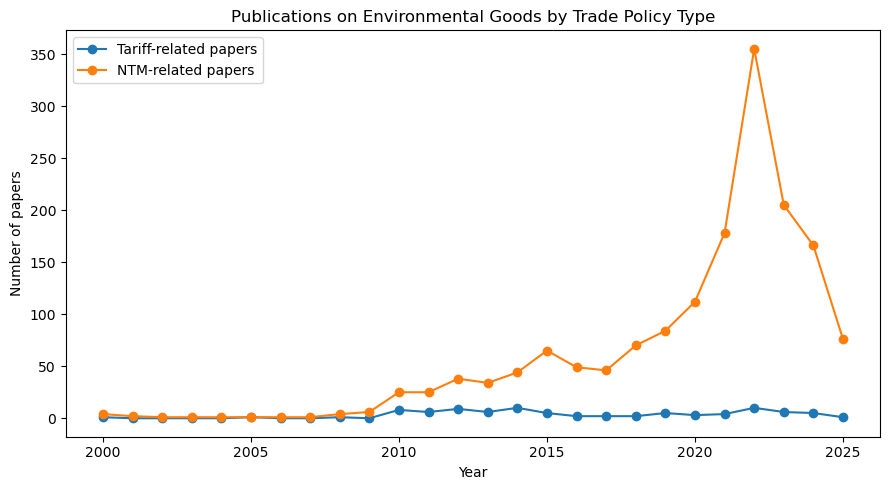

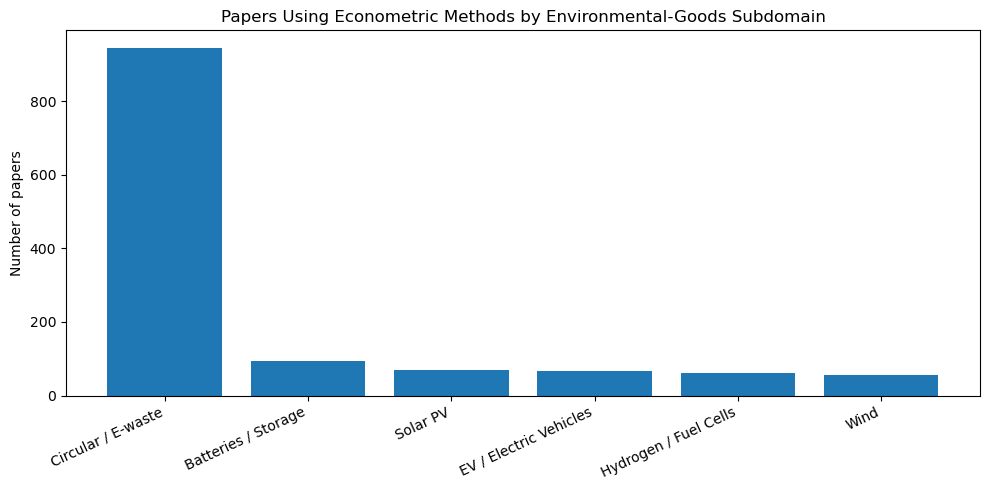

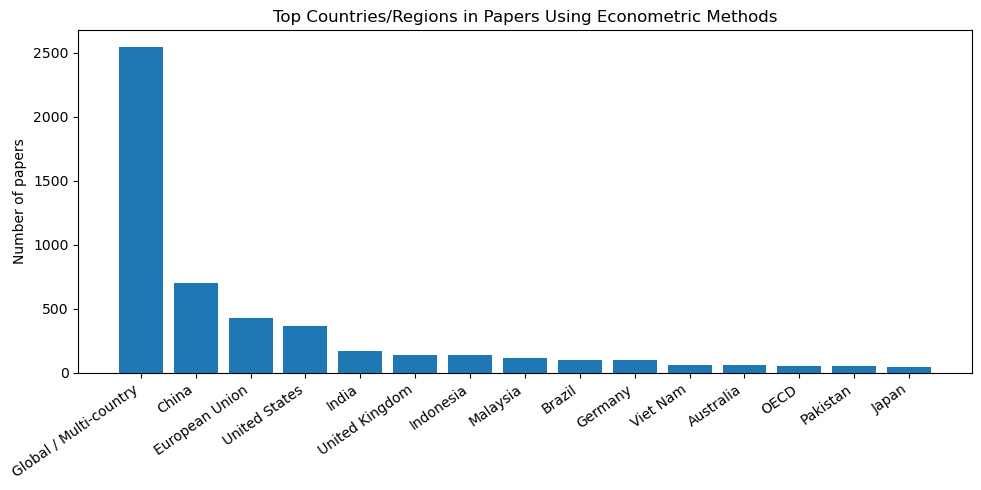

Saved charts:
C:\Users\DOROTHEA RAMIZO\Desktop\PhD Data\RRL\3rd Essay\DL\charts\chart_time_trend_tariff_vs_ntm.png
C:\Users\DOROTHEA RAMIZO\Desktop\PhD Data\RRL\3rd Essay\DL\charts\bar_eg_econometrics.png
C:\Users\DOROTHEA RAMIZO\Desktop\PhD Data\RRL\3rd Essay\DL\charts\bar_countries_econometrics.png
Saved tables:
C:\Users\DOROTHEA RAMIZO\Desktop\PhD Data\RRL\3rd Essay\DL\charts\econometrics_eg_counts.csv
C:\Users\DOROTHEA RAMIZO\Desktop\PhD Data\RRL\3rd Essay\DL\charts\econometrics_policy_focus.csv
C:\Users\DOROTHEA RAMIZO\Desktop\PhD Data\RRL\3rd Essay\DL\charts\econometrics_country_counts.csv
C:\Users\DOROTHEA RAMIZO\Desktop\PhD Data\RRL\3rd Essay\DL\charts\econometrics_country_by_eg_matrix.csv
(i) Econometrics papers mentioning tariff and/or NTM: 1,473 out of 8,717 (16.9%).
(ii) Econometrics papers mentioning tariff/NTM AND an EG subdomain: 214 out of 8,717 (2.5%).
    Of 7,117 econometrics papers: 20.7% mention tariff/NTM; 3.0% mention tariff/NTM AND an EG subdomain.


In [43]:
# Breakdown of goods (EG subdomains) and country coverage within ECONOMETRICS papers
# + Time trend (Tariff vs NTM) covering environmental goods
# - Adds "Global / Multi-country" bucket to country patterns
# - Uses Windows-safe paths (no /mnt/data)
# - Saves charts + CSVs to ...\DL\charts\

import pandas as pd
import re
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------- Paths (EDIT if needed) ----------------
dataset_path = Path(r"C:\Users\DOROTHEA RAMIZO\Desktop\PhD Data\RRL\3rd Essay\DL\master_screened_by_fos.csv")
out_dir      = Path(r"C:\Users\DOROTHEA RAMIZO\Desktop\PhD Data\RRL\3rd Essay\DL\charts")
out_dir.mkdir(parents=True, exist_ok=True)

chart_trend_path    = out_dir / "chart_time_trend_tariff_vs_ntm.png"
chart_eg_path       = out_dir / "bar_eg_econometrics.png"
chart_country_path  = out_dir / "bar_countries_econometrics.png"
csv_eg_counts       = out_dir / "econometrics_eg_counts.csv"
csv_policy_focus    = out_dir / "econometrics_policy_focus.csv"
csv_country_counts  = out_dir / "econometrics_country_counts.csv"
csv_country_by_eg   = out_dir / "econometrics_country_by_eg_matrix.csv"

# ---------------- Load dataset ----------------
df = pd.read_csv(dataset_path)

# Ensure text columns exist
for col in ["title", "abstract", "fields_of_study"]:
    if col not in df.columns:
        df[col] = ""

# Unified text to scan
def unify_text(row):
    return " ".join([str(row.get(c, "")) for c in ["title", "abstract", "fields_of_study"]]).lower()

df["_text"] = df.apply(unify_text, axis=1)

# ---------------- Keyword sets ----------------
eg_map = {
    "EV / Electric Vehicles": [r"\belectric vehicle\b", r"\belectric vehicles\b", r"\bev\b", r"\bevs\b"],
    "Hydrogen / Fuel Cells": [r"\bhydrogen\b", r"\bfuel cell\b", r"\bfuel cells\b", r"\belectrolyser\b", r"\belectrolyzer\b", r"\bammonia\b"],
    "Solar PV": [r"\bsolar photovoltaic\b", r"\bsolar pv\b", r"\bphotovoltaic\b"],
    "Wind": [r"\bwind turbine\b", r"\bwind power\b", r"\bwind energy\b"],
    "Batteries / Storage": [r"\bbattery\b", r"\bbatteries\b", r"\benergy storage\b", r"\baccumulator\b"],
    "Circular / E-waste": [r"\bcircular economy\b", r"\brecycling\b", r"\be-waste\b", r"\belectronic waste\b"]
}

tariff_terms = ["tariff", "tariffs", "import duty", "ad valorem", "customs duty"]
ntm_terms = [
    "non-tariff", "non tariff", "technical barriers to trade", "tbt",
    "sanitary and phytosanitary", "sps", "standard", "standards",
    "regulation", "regulatory", "cbam", "border adjustment"
]

# ECONOMETRICS methods (no causal claim implied)
econometrics_terms = [
    "gravity model", "structural gravity", "ppml", "poisson pseudo-maximum likelihood",
    "gmm", "system gmm", "iv", "instrumental variable",
    "difference-in-differences", "diff-in-diff", "event study",
    "panel fixed effects", "two-way fixed effects", "twfe",
    "panel regression", "ols", "maximum likelihood", "endogeneity"
]

# Country / region patterns (+ Global bucket)
country_patterns = {
    "Global / Multi-country": [
        r"\bglobal\b", r"\bworld\b", r"\bworldwide\b",
        r"\binternational\b", r"\bcross-?country\b", r"\bmulti-?country\b",
        r"\bpanel of countries\b", r"\bmultiple countries\b",
        r"\bglobal value chains?\b", r"\bgvc\b"
    ],
    "China": [r"\bchina\b", r"\bprc\b"],
    "United States": [r"\bunited states\b", r"\busa\b", r"\bu\.s\.\b", r"\bus\b"],
    "European Union": [r"\beuropean union\b", r"\beu\b", r"\beu-?27\b"],
    "Germany": [r"\bgermany\b"],
    "France": [r"\bfrance\b"],
    "United Kingdom": [r"\b(united kingdom|uk)\b"],
    "Japan": [r"\bjapan\b"],
    "Korea, Rep.": [r"\bsouth korea\b", r"\brepublic of korea\b", r"\bkorea\b"],
    "India": [r"\bindia\b"],
    "Indonesia": [r"\bindonesia\b"],
    "Malaysia": [r"\bmalaysia\b"],
    "Philippines": [r"\bphilippines\b"],
    "Thailand": [r"\bthailand\b"],
    "Viet Nam": [r"\bviet\s?nam\b", r"\bvietnam\b"],
    "Singapore": [r"\bsingapore\b"],
    "Taipei,China": [r"\btaiwan\b", r"\bchinese taipei\b"],
    "Hong Kong, China": [r"\bhong kong\b"],
    "Australia": [r"\baustralia\b"],
    "New Zealand": [r"\bnew zealand\b"],
    "Canada": [r"\bcanada\b"],
    "Mexico": [r"\bmexico\b"],
    "Brazil": [r"\bbrazil\b"],
    "South Africa": [r"\bsouth africa\b"],
    "Russia": [r"\brussia\b", r"\brussian federation\b"],
    "Turkey": [r"\bturkey\b", r"\btürkiye\b"],
    "Saudi Arabia": [r"\bsaudi arabia\b"],
    "United Arab Emirates": [r"\bunited arab emirates\b", r"\bu\.a\.e\.\b", r"\buae\b"],
    "Egypt": [r"\begypt\b"],
    "Pakistan": [r"\bpakistan\b"],
    "Bangladesh": [r"\bbangladesh\b"],
    "Kazakhstan": [r"\bkazakhstan\b"],
    "Uzbekistan": [r"\buzbekistan\b"],
    "Mongolia": [r"\bmongolia\b"],
    "OECD": [r"\boecd\b"],
    "ASEAN": [r"\basean\b"],
    "BRICS": [r"\bbrics\b"],
    "G7": [r"\bg7\b"],
    "G20": [r"\bg20\b"]
}

# ---------------- Helpers ----------------
def contains_any(text, terms):
    t = text.lower()
    for term in terms:
        if re.search(term if term.startswith(r"\b") else re.escape(term), t):
            return True
    return False

def contains_any_regex(text, patterns):
    for p in patterns:
        if re.search(p, text):
            return True
    return False

# Flags for policy and econometrics
df["_has_tariff"]      = df["_text"].apply(lambda x: contains_any(x, tariff_terms))
df["_has_ntm"]         = df["_text"].apply(lambda x: contains_any(x, ntm_terms))
df["_is_econometrics"] = df["_text"].apply(lambda x: contains_any(x, econometrics_terms))

# EG flags
for cat, pats in eg_map.items():
    df[f"_eg_{cat}"] = df["_text"].apply(lambda x: contains_any_regex(x, pats))

# Country matches (set of unique hits per record)
def match_countries(text):
    t = str(text).lower()
    hits = []
    for name, pats in country_patterns.items():
        for p in pats:
            if re.search(p, t):
                hits.append(name)
                break
    return sorted(set(hits))

df["_matched_countries"] = df["_text"].apply(match_countries)

# ---------------- TIME TREND: NTM vs Tariff (EG context) ----------------
year_col = next((c for c in ["year", "publication_year", "pub_year", "Year"] if c in df.columns), None)
if year_col is None:
    for c in ["date", "publication_date", "pub_date"]:
        if c in df.columns:
            y = pd.to_datetime(df[c], errors="coerce").dt.year
            if y.notna().any():
                df["_year"] = y
                year_col = "_year"
                break

plt.figure(figsize=(9, 5))
if year_col is not None:
    yrs = pd.to_numeric(df[year_col], errors="coerce")
    timeline = (
        df.assign(_year_num=yrs)
          .dropna(subset=["_year_num"])
          .groupby("_year_num")
          .agg(tariff=("_has_tariff", "sum"),
               ntm=("_has_ntm", "sum"))
          .reset_index()
          .sort_values("_year_num")
    )
    plt.plot(timeline["_year_num"], timeline["tariff"], marker="o", label="Tariff-related papers")
    plt.plot(timeline["_year_num"], timeline["ntm"], marker="o", label="NTM-related papers")
    plt.xlabel("Year")
else:
    counts = pd.Series({
        "Tariff-related papers": int(df["_has_tariff"].sum()),
        "NTM-related papers": int(df["_has_ntm"].sum())
    })
    counts.plot(kind="bar")
    plt.xticks(rotation=0)

plt.title("Publications on Environmental Goods by Trade Policy Type")
plt.ylabel("Number of papers")
plt.legend()
plt.tight_layout()
plt.savefig(chart_trend_path, dpi=200)
plt.show()

# ---------------- Focus on ECONOMETRICS subset ----------------
econ_df = df[df["_is_econometrics"]].copy()

# 1) EG subdomains within econometrics subset
eg_counts = [(cat, int(econ_df[f"_eg_{cat}"].sum())) for cat in eg_map.keys()]
eg_counts_df = pd.DataFrame(eg_counts, columns=["EG Subdomain", "Econometrics Paper Count"]).sort_values(
    "Econometrics Paper Count", ascending=False
)

# 2) Policy focus within econometrics subset
policy_rows = [
    ("Tariff-only", int(((econ_df["_has_tariff"]) & (~econ_df["_has_ntm"])).sum())),
    ("NTM-only", int(((~econ_df["_has_tariff"]) & (econ_df["_has_ntm"])).sum())),
    ("Both Tariff and NTM", int(((econ_df["_has_tariff"]) & (econ_df["_has_ntm"])).sum()))
]
policy_df = pd.DataFrame(policy_rows, columns=["Policy Focus", "Econometrics Paper Count"]).sort_values(
    "Econometrics Paper Count", ascending=False
)

# 3) Country/region coverage within econometrics subset (includes Global / Multi-country)
country_count = {}
for hits in econ_df["_matched_countries"]:
    for h in hits:
        country_count[h] = country_count.get(h, 0) + 1
country_counts_df = (
    pd.DataFrame({"Country/Region": list(country_count.keys()), "Econometrics Paper Count": list(country_count.values())})
    .sort_values("Econometrics Paper Count", ascending=False)
    .reset_index(drop=True)
)

# 4) Country × EG subdomain matrix (Top 12 countries/regions by count)
top12 = country_counts_df.head(12)["Country/Region"].tolist()
pairs = []
for _, row in econ_df.iterrows():
    c_hits = [c for c in row["_matched_countries"] if c in top12]
    if not c_hits:
        continue
    eg_hits = [cat for cat in eg_map.keys() if row.get(f"_eg_{cat}", False)]
    if not eg_hits:
        continue
    for c in c_hits:
        for e in eg_hits:
            pairs.append((c, e))
pair_df = pd.DataFrame(pairs, columns=["Country/Region", "EG Subdomain"])
matrix_df = pair_df.pivot_table(index="Country/Region", columns="EG Subdomain", aggfunc="size", fill_value=0)

# ---------------- Charts (econometrics subset) ----------------
# A) Econometrics subset by EG subdomain
plt.figure(figsize=(10, 5))
plt.bar(eg_counts_df["EG Subdomain"], eg_counts_df["Econometrics Paper Count"])
plt.title("Papers Using Econometric Methods by Environmental-Goods Subdomain")
plt.ylabel("Number of papers")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.savefig(chart_eg_path, dpi=200)
plt.show()

# B) Top 15 countries/regions (includes 'Global / Multi-country' if present)
top15 = country_counts_df.head(15)
plt.figure(figsize=(10, 5))
plt.bar(top15["Country/Region"], top15["Econometrics Paper Count"])
plt.title("Top Countries/Regions in Papers Using Econometric Methods")
plt.ylabel("Number of papers")
plt.xticks(rotation=35, ha="right")
plt.tight_layout()
plt.savefig(chart_country_path, dpi=200)
plt.show()

# ---------------- Save CSVs ----------------
eg_counts_df.to_csv(csv_eg_counts, index=False)
policy_df.to_csv(csv_policy_focus, index=False)
country_counts_df.to_csv(csv_country_counts, index=False)
matrix_df.to_csv(csv_country_by_eg)

print("Saved charts:")
print(chart_trend_path)
print(chart_eg_path)
print(chart_country_path)
print("Saved tables:")
print(csv_eg_counts)
print(csv_policy_focus)
print(csv_country_counts)
print(csv_country_by_eg)

# ---------------- Summary print for supervisor slide ----------------
# (i) Econometrics papers that mention tariff AND/OR NTM out of total
# (ii) Econometrics papers that mention tariff/NTM AND an EG subdomain out of total

# Build an "any EG subdomain" flag from the EG columns you already created
eg_cols = [f"_eg_{cat}" for cat in eg_map.keys() if f"_eg_{cat}" in df.columns]
df["_has_any_eg"] = df[eg_cols].any(axis=1) if eg_cols else False

total_records = int(len(df))
econ_mask     = df["_is_econometrics"]
policy_mask   = df["_has_tariff"] | df["_has_ntm"]

econ_policy_mask    = econ_mask & policy_mask
econ_policy_count   = int(econ_policy_mask.sum())

econ_policy_eg_mask  = econ_policy_mask & df["_has_any_eg"]
econ_policy_eg_count = int(econ_policy_eg_mask.sum())

# Nice prints with thousands separators and percents of TOTAL (e.g., 8,717)
print(f"(i) Econometrics papers mentioning tariff and/or NTM: "
      f"{econ_policy_count:,} out of {total_records:,} "
      f"({(econ_policy_count/total_records*100 if total_records else 0):.1f}%).")

print(f"(ii) Econometrics papers mentioning tariff/NTM AND an EG subdomain: "
      f"{econ_policy_eg_count:,} out of {total_records:,} "
      f"({(econ_policy_eg_count/total_records*100 if total_records else 0):.1f}%).")

# (Optional) also show shares within the econometrics subset itself
econ_total = int(econ_mask.sum())
if econ_total > 0:
    print(f"    Of {econ_total:,} econometrics papers: "
          f"{(econ_policy_count/econ_total*100):.1f}% mention tariff/NTM; "
          f"{(econ_policy_eg_count/econ_total*100):.1f}% mention tariff/NTM AND an EG subdomain.")